## Data loader testing

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('../')
print(os.getcwd())

/home/yoyee/Documents/deepSfm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def loadConfig(filename):
    import yaml
    with open(filename, 'r') as f:
        config = yaml.load(f)
    return config


In [10]:
# load config
logging.basicConfig(format='[%(asctime)s %(levelname)s] %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)


filename = 'configs/superpoint_coco_test.yaml'
# filename = 'configs/magicpoint_repeatability.yaml'
config = loadConfig(filename)
print("config path: ", filename)
print("config: ", config)

config path:  configs/superpoint_coco_test.yaml
config:  {'data': {'name': 'coco', 'dataset': 'coco', 'labels': 'magicpoint_synth20_homoAdapt100_coco/predictions', 'cache_in_memory': False, 'validation_size': 10, 'preprocessing': {'resize': [240, 320]}, 'augmentation': {'photometric': {'enable': True, 'primitives': ['random_brightness', 'random_contrast', 'additive_speckle_noise', 'additive_gaussian_noise', 'additive_shade', 'motion_blur'], 'params': {'random_brightness': {'max_abs_change': 50}, 'random_contrast': {'strength_range': [0.5, 1.5]}, 'additive_gaussian_noise': {'stddev_range': [0, 10]}, 'additive_speckle_noise': {'prob_range': [0, 0.0035]}, 'additive_shade': {'transparency_range': [-0.5, 0.5], 'kernel_size_range': [100, 150]}, 'motion_blur': {'max_kernel_size': 3}}}, 'homographic': {'enable': False}}, 'warped_pair': {'enable': True, 'params': {'translation': True, 'rotation': True, 'scaling': True, 'perspective': True, 'scaling_amplitude': 0.2, 'perspective_amplitude_x': 0.

In [11]:
task = config['data']['dataset']
print("task: ", task)

# data
from utils.loader import dataLoader
data = dataLoader(config, dataset=task, warp_input=True)
train_loader, val_loader = data['train_loader'], data['val_loader']
# # data loading
# from utils.loader import dataLoader_test as dataLoader
# data = dataLoader(config, dataset=task)
# test_set, test_loader = data['test_set'], data['test_loader']

logging.info('== train split size %d in %d batches, val split size %d in %d batches'%\
        (len(train_loader)*config['model']['batch_size'], len(train_loader),
         len(val_loader)*config['model']['batch_size'], len(val_loader)))



task:  coco
load labels from:  magicpoint_synth20_homoAdapt100_coco/predictions/train
load labels from:  magicpoint_synth20_homoAdapt100_coco/predictions/val


[04/25/2019 14:52:45 INFO] == train split size 82783 in 82783 batches, val split size 40504 in 40504 batches


In [12]:
# # val
# for i, sample in enumerate(val_loader):
#     if i% 100 == 0:
#         print(list(sample))
#         break
# train
print("load training samples")
for i, sample in enumerate(train_loader):
    if i% 100 == 0:
        print(list(sample))
        break


load training samples
['image', 'valid_mask', 'labels_2D', 'warped_img', 'warped_labels', 'warped_valid_mask', 'homographies', 'inv_homographies', 'name']


In [13]:
device = 'cpu'
# get model
def loadModel(config, device='cpu'):
    from models.model_wrap import SuperPointFrontend_torch

    path = config['pretrained']
    print('==> Loading pre-trained network.')
    print('path: ', path)
    # This class runs the SuperPoint network and processes its outputs.

    nms_dist = config['model']['nms']
    conf_thresh = config['model']['detection_threshold']
    nn_thresh = config['model']['nn_thresh']

    print('nms_dist = ', nms_dist)
    print('conf_thresh = ', conf_thresh)
    print('nn_thresh = ', nn_thresh)

    fe = SuperPointFrontend_torch(weights_path=path,
                            nms_dist=nms_dist,
                            conf_thresh=conf_thresh,
                            nn_thresh=nn_thresh,
                            cuda=False,
                            device=device)
    print('==> Successfully loaded pre-trained network.')
    print(path)
    return fe

fe = loadModel(config, device=device)

==> Loading pre-trained network.
path:  ../deepSfm/logs/superpoint_kitti30_1/checkpoints/superPointNet_170000_checkpoint.pth.tar
nms_dist =  4
conf_thresh =  0.015
nn_thresh =  0.7
model structure: relu - bn - conv
apply batch norm!
==> Successfully loaded pre-trained network.
../deepSfm/logs/superpoint_kitti30_1/checkpoints/superPointNet_170000_checkpoint.pth.tar


In [14]:

# visualize the matchings
import cv2

def draw_matches_cv(data):
    keypoints1 = [cv2.KeyPoint(p[1], p[0], 1) for p in data['keypoints1']]
    keypoints2 = [cv2.KeyPoint(p[1], p[0], 1) for p in data['keypoints2']]
    inliers = data['inliers'].astype(bool)
    matches = np.array(data['matches'])[inliers].tolist()
    def to3dim(img):
        if img.ndim == 2:
            img = img[:, :, np.newaxis]
        return img
    img1 = to3dim(data['image1'])
    img2 = to3dim(data['image2'])
    img1 = np.concatenate([img1, img1, img1], axis=2)
    img2 = np.concatenate([img2, img2, img2], axis=2)
    return cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches,
                           None, matchColor=(0,255,0), singlePointColor=(0, 0, 255))

def visualize_matches(image, warped_image, result, filename='test.png'):
    from utils.draw import plot_imgs
    from utils.utils import pltImshow
    # draw matches
    result['image1'] = image
    result['image2'] = warped_image
    img = draw_matches_cv(result)
    # filename = "correspondence_visualization"
    plot_imgs([img], titles=["Two images feature correspondences"], dpi=200)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.close('all')
    pltImshow(img)
    plt.show()
    pass

# data = pred
# from evaluations.descriptor_evaluation import compute_homography
# homography_thresh = [1,3,5]

# result = compute_homography(pred, correctness_thresh=homography_thresh)

# visualize_matches(squeezeToNumpy(img_0), squeezeToNumpy(img_1), result)

# calculate the homography

# report the score

['image', 'valid_mask', 'labels_2D', 'warped_img', 'warped_labels', 'warped_valid_mask', 'homographies', 'inv_homographies', 'name']
pts_id:  (2, 421)
desc:  (256, 421)


[04/25/2019 23:09:53 WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


matches:  (62, 4)
total points:  (3, 429)
pred:  ['image', 'prob', 'desc', 'warped_image', 'matches', 'warped_prob', 'warped_desc', 'homography']
shape:  (240, 320)
desc:  (421, 256)
w desc:  (429, 256)
corner:  [[  0   0   1]
 [  0 239   1]
 [319   0   1]
 [319 239   1]]
real_warped_corners:  [[-0.09131226 -0.07342697]
 [-4.71281852 -8.46077979]
 [-4.62727638  2.76649775]
 [-4.6080622  -0.57313537]]
warped_corners:  [[ -10.4280172     3.49329888]
 [  14.23346866  748.31747594]
 [ 233.40775957 -191.25314845]
 [ 483.09607624  387.60688384]]


[04/25/2019 23:09:54 WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


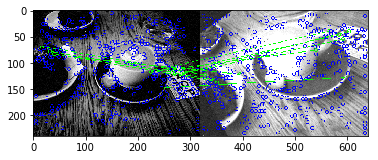

In [115]:
## warp image
# from utils.utils import pltImshow, saveImg
# def tensorto4d(inp):
#     if len(inp.shape) == 2:
#         inp = inp.view(1, 1, inp.shape[0], inp.shape[1])
#     elif len(inp.shape) == 3:
#         inp = inp.view(1, inp.shape[0], inp.shape[1], inp.shape[2])
#     return inp

from imageio import imread
def load_as_float(path):
    return imread(path).astype(np.float32) / 255

def squeezeToNumpy(tensor_arr):
    return tensor_arr.detach().cpu().numpy().squeeze()

def getTracker(max_length):
    from models.model_wrap import SuperPointFrontend, SuperPointFrontend_torch, PointTracker
    tracker = PointTracker(max_length, nn_thresh=fe.nn_thresh)
    return tracker

max_length = 5
tracker = getTracker(max_length)

outputMatches = True
count = 0
iter_max = 1

# for to get data
# export points and descriptors

for i, sample in enumerate(train_loader):
    if i < iter_max:
        print(list(sample))
        img_0, img_1 = sample['image'], sample['warped_img']

        # first image, no matches
        img = img_0
        # H, W = img.shape[1], img.shape[2]
        # img = img.view(1,1,H,W)

        pts, desc, _, heatmap = fe.run(img)
        pts = pts[0]
        desc = desc[0]
        '''
        pts: list [numpy (N, 3)]
        desc: list [numpy (N, 256)]
        '''
        if outputMatches == True:
            tracker.update(pts, desc)
        # save keypoints
        pts_id = pts[:2, :]
        pred = {'image': squeezeToNumpy(img_0)}
        pred.update({'prob': pts.transpose(),
                     'desc': desc.transpose()})
        
        print("pts_id: ", pts_id.shape)
        print("desc: ", desc.shape)

        # second image, output matches
        img = img_1
        pred.update({'warped_image': squeezeToNumpy(img_1)})
        pts, desc, _, heatmap = fe.run(img)
        pts = pts[0]
        desc = desc[0]

        if outputMatches == True:
            tracker.update(pts, desc)

            matches = tracker.get_matches()
            print("matches: ", matches.transpose().shape)
            pred.update({'matches': matches.transpose()})
        print("total points: ", pts.shape)
        pred.update({'warped_prob': pts.transpose(),
                     'warped_desc': desc.transpose(),
                     'homography': squeezeToNumpy(sample['homographies'])
                     })
        # clean last descriptor
        '''
        pred:
            'image': np(320,240)
            'prob' (keypoints): np (N1, 2)
            'desc': np (N2, 256)
            'warped_image': np(320,240)
            'warped_prob' (keypoints): np (N2, 2)
            'warped_desc': np (N2, 256)
            'homography': np (3,3)

        '''
        tracker.clear_desc()
        
        print("pred: ", list(pred))
        
        # viualize matches
        data = pred
        from evaluations.descriptor_evaluation import compute_homography
        homography_thresh = [1,3,5]

        result = compute_homography(pred, correctness_thresh=homography_thresh)

        visualize_matches(squeezeToNumpy(img_0), squeezeToNumpy(img_1), result)
        
    else: break
        


In [131]:
points = fe.soft_argmax_points()
# print("points: ", points.shape)
print(points)

not take care of batch! only take first element!
heatmap:  (244, 324)
patches:  torch.Size([1, 429, 5, 5])
pts:  (429, 3)
dxdy:  torch.Size([1, 429, 2])
[array([[2.81998908e+02, 1.85000578e+02, 1.32998591e+02, ...,
        2.91000622e+02, 2.59000417e+02, 5.29998940e+01],
       [8.50017831e+01, 1.69000720e+02, 1.09996933e+02, ...,
        4.99996590e+01, 6.19995799e+01, 2.02001682e+02],
       [3.72512370e-01, 2.51099437e-01, 2.28458136e-01, ...,
        1.51691502e-02, 1.51569685e-02, 1.51355835e-02]])]


In [135]:
points = fe.points
print(points[0])

get pts
[[2.82000000e+02 1.85000000e+02 1.33000000e+02 ... 2.91000000e+02
  2.59000000e+02 5.30000000e+01]
 [8.50000000e+01 1.69000000e+02 1.10000000e+02 ... 5.00000000e+01
  6.20000000e+01 2.02000000e+02]
 [3.72512370e-01 2.51099437e-01 2.28458136e-01 ... 1.51691502e-02
  1.51569685e-02 1.51355835e-02]]


In [136]:
pts = points[0]
# pts = pts[[1, 0], :]

[04/25/2019 23:16:45 WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img_1:  torch.Size([1, 1, 240, 320])


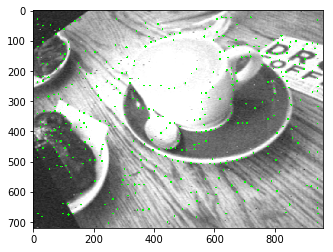

heatmap:  0.0035829938


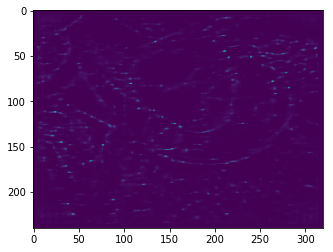

In [137]:
# print image with points
from utils.draw import draw_keypoints
from utils.utils import toNumpy

print("img_1: ", img_1.shape)

img = draw_keypoints(toNumpy(img_1.squeeze()), pts)
# print("img: ", img_0)
plt.imshow(img)
plt.show()


print("heatmap: ", toNumpy(heatmap).mean())
plt.imshow(toNumpy(heatmap.squeeze()))
plt.show()


# extract patches

# do soft argmax

In [39]:
print("points: ", pts.shape)
point = pts[:,0]
print("point: ", point)

points:  (3, 443)
point:  [263.         188.           0.39999139]


heatmap:  (244, 324)
patch:  (5, 5)
patch:  (5, 5)
patch:  (5, 5)
patch:  (5, 5)
patch:  (5, 5)
patch:  (5, 5)
patch:  (5, 5)
patch:  (5, 5)
patch:  (5, 5)
patch:  (5, 5)
patch:  (5, 5)
patch:  (5, 5)


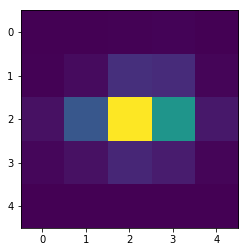

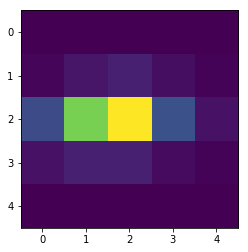

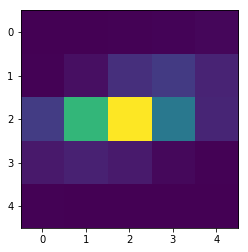

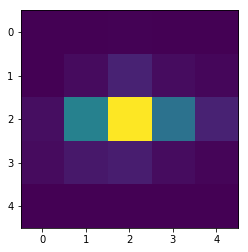

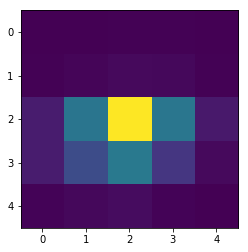

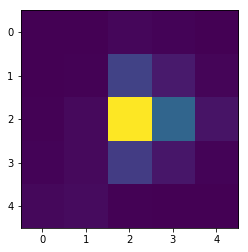

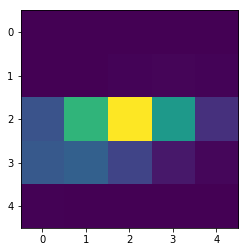

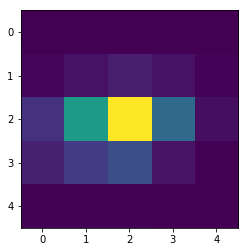

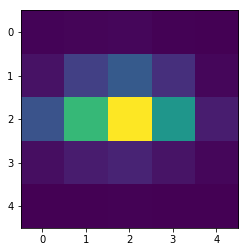

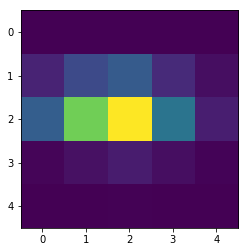

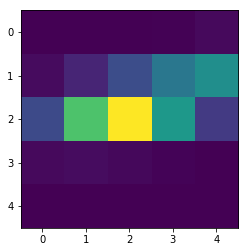

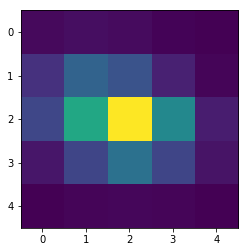

patches:  torch.Size([1, 12, 5, 5])


In [61]:
def extract_patch(heatmap, points, patch_size=5):
    # numpy
    heatmap = toNumpy(heatmap).squeeze()  # [H, W]
    # padding
    pad_size = int(patch_size/2)
    heatmap = np.pad(heatmap, pad_size, 'constant')
    # crop it
    patches = []
    ext = lambda img, pnt, wid: img[pnt[1]:pnt[1]+wid, pnt[0]:pnt[0]+wid]
    print("heatmap: ", heatmap.shape)
    for i in range(points.shape[0]):
#         print("point: ", points[i,:])
        patch = ext(heatmap, points[i,:].astype(int), patch_size)
        print("patch: ", patch.shape)
        patches.append(patch)
        
        if i > 10: break
    # extract points
    return patches
    
patches = extract_patch(heatmap, pts.transpose(), patch_size=5)
# print("patches", patches)
for i in patches:
    plt.imshow(i)
    plt.show()

import torch
patches = np.stack(patches)
patches_torch = torch.tensor(patches, dtype=torch.float32).unsqueeze(0)
print("patches: ", patches_torch.shape)
    


In [62]:
import torch
import torchgeometry as tgm

# input = torch.rand(1, 4, 2, 3)
input = patches_torch
m = tgm.contrib.SpatialSoftArgmax2d()
coords = m(input)  # 1x4x2
x_coord, y_coord = torch.chunk(coords, dim=-1, chunks=2)

print("(x_coord, x_coord)", x_coord, y_coord)

(x_coord, x_coord) tensor([[[ 0.0038],
         [-0.0067],
         [-0.0016],
         [ 0.0002],
         [-0.0010],
         [ 0.0022],
         [-0.0053],
         [-0.0035],
         [-0.0030],
         [-0.0046],
         [ 0.0037],
         [-0.0038]]]) tensor([[[-5.9551e-04],
         [ 2.9786e-04],
         [-1.3602e-03],
         [ 1.5780e-04],
         [ 4.5662e-03],
         [ 2.4125e-04],
         [ 4.0180e-03],
         [ 1.6454e-03],
         [-1.8921e-03],
         [-2.3226e-03],
         [-5.0900e-03],
         [-7.4659e-05]]])


In [ ]:
squeezeToNumpy(img_1).shape
# matches(squeezeToNumpy(img_0), squeezeToNumpy(img_1), result)
list(result)

In [ ]:
print(list(result))
print("correctness: ", result['correctness'])
print("gt homography: ", data['homographies'])
print("est homography: ", result['homography'])


In [ ]:
from utils.draw import plot_imgs


## visualize data

In [ ]:
import torch

In [ ]:
# print shape
entries = list(sample)
for i in entries:
    element = sample[i]
#     print(type(element))
    if type(element) is torch.Tensor:
        print("shape of ", i, " ", element.shape)
img, labels_2D, mask_2D = sample['image'], sample['labels_2D'], sample['valid_mask']


In [ ]:
def img_overlap(img_r, img_g, img_gray):  # img_b repeat
    img = np.concatenate((img_gray, img_gray, img_gray), axis=0)
    img[0, :, :] += img_r[0, :, :]
    img[1, :, :] += img_g[0, :, :]
    img[img > 1] = 1
    img[img < 0] = 0
    img = img.transpose([1,2,0])
    return img
def toNumpy(tensor):
    return tensor.detach().cpu().numpy()

result_overlap = img_overlap(toNumpy(1 - mask_2D[0,:,:,:]), toNumpy(labels_2D[0, :, :, :]), toNumpy(img[0, :, :, :]))
print(result_overlap.shape)

plt.imshow(result_overlap)
plt.show()

## Visualize warped images (for joint training)

In [ ]:
# entries = ['image', 'labels_2D', 'valid_mask', 'overlay']
entries = ['warped_img', 'warped_labels', 'warped_valid_mask', 'overlay']
cols = len(entries)
scale = 10


In [ ]:
# show images
count = 1
images_num = 2
col_row_ratio = 3
rows = images_num
plt.figure(figsize=(cols*col_row_ratio*scale, rows*scale))

task_folder = ['matching']
for i in range(images_num):
    for j in range(cols):
#         exp_path = Path(base_path, folder[j], prediction, task_folder[0])
#         path = exp_path / (str(i) + 'm.png')
#         image = load_as_float(path)
        print(entries[j])

        if entries[j] == 'overlay':
            img, labels_2D, mask_2D = sample[entries[0]], sample[entries[1]], sample[entries[2]]
            image = img_overlap(toNumpy(1 - mask_2D[i,:,:,:]), 
                toNumpy(labels_2D[i, :, :, :]), toNumpy(img[i, :, :, :]))
        else:
            image = sample[entries[j]][i,0,:,:]
            image = image.numpy()
        plt.subplot(rows, cols, count)
        count += 1
        plt.axis('off')
        plt.title(entries[j] + '/' + str(i))
        plt.imshow(image, cmap='gray')
        plt.tight_layout()
plt.show()

## Visualize images w/o homography augmentation

In [ ]:
entries = ['image', 'labels_2D', 'valid_mask', 'overlay']
# entries = ['warped_img', 'warped_labels', 'warped_valid_mask', 'overlay']
cols = len(entries)
scale = 10


In [ ]:
# show images
count = 1
images_num = 2
col_row_ratio = 3
rows = images_num
plt.figure(figsize=(cols*col_row_ratio*scale, rows*scale))

task_folder = ['matching']
for i in range(images_num):
    for j in range(cols):
#         exp_path = Path(base_path, folder[j], prediction, task_folder[0])
#         path = exp_path / (str(i) + 'm.png')
#         image = load_as_float(path)
        print(entries[j])

        if entries[j] == 'overlay':
            img, labels_2D, mask_2D = sample[entries[0]], sample[entries[1]], sample[entries[2]]
            image = img_overlap(toNumpy(1 - mask_2D[i,:,:,:]), 
                toNumpy(labels_2D[i, :, :, :]), toNumpy(img[i, :, :, :]))
        else:
            image = sample[entries[j]][i,0,:,:]
            image = image.numpy()
        plt.subplot(rows, cols, count)
        count += 1
        plt.axis('off')
        plt.title(entries[j] + '/' + str(i))
        plt.imshow(image, cmap='gray')
        plt.tight_layout()
plt.show()

In [ ]:
mask_2D.shape